In [1]:
import drdf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_drdf(fname):
  reader = drdf.DRDF()
  reader.read(fname)
  events = []
  for run in reader.runs:
    for event in reader.runs[run]:
      hits_map = dict()
      for cam, img in reader.runs[run][event].items():
        amplitude = img.pixels[:, :, 0] 
        time = img.pixels[:, :, 1]
        hits_map[cam] = amplitude
      events.append((event, hits_map))
  return events

In [3]:
#file_drdf_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/initial_data_good/response.drdf","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data/response_pde25.drdf","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data2/response.drdf","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data3/response.drdf"]
#file_root_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/initial_data_good/sensors.root","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data/sensors_pde25.root","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data2/sensors.root","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/new_data3/sensors.root"]

file_drdf_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last1/response.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last2/response.drdf"]
file_root_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last1/sensors.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last2/sensors.root"]

In [4]:
def CamList(fname):
    cam_list = []
    file = load_drdf(fname)
    for cam in file[0][1]:
        cam_list.append(cam)
    return cam_list

In [5]:
#creo una matrice 1000 righe x 54 colonne. ogni elemento è una camera 31x31
def AllImages(fname): 
    all_images_list = []
    cam_list = CamList(fname)
    file = load_drdf(fname)
    for i in range(len(file)):
        ph_matrix = []
        for cam in cam_list:
            ph_matrix.append(file[i][1][cam])
        all_images_list.append(ph_matrix)
    all_images = np.array(all_images_list)
    return all_images

In [6]:
def DimensionsData(fname):
    all_images = AllImages(fname)
    cam_list = CamList(fname)
    nr_events = len(all_images)
    nr_pixels = len(all_images[0][0])
    nr_cams = len(cam_list)
    nr_tot_events = nr_cams*nr_events
    nr_pixels_1_ev = nr_pixels*nr_pixels*nr_cams
    return nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev

In [7]:
#creo una matrice di 1000 righe e 51894 colonne. Così per ogni evento, la riga corrispondente presenta tutti i pixel di tutte le camere
def PixelsAllCamsPerEvents(fname):
    all_images = AllImages(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    pixels_to_scale = []
    for images_all_cams_per_ev in all_images: 
        pixels_all_cams_per_ev = images_all_cams_per_ev.flatten()
        pixels_to_scale.append(pixels_all_cams_per_ev)
    pixels_to_scale = np.asarray(pixels_to_scale)
    pixels_to_scale_matrix = pixels_to_scale.reshape(nr_events,nr_pixels_1_ev,1)
    return pixels_to_scale_matrix

In [8]:
def PlotCamsImages(fname):
    all_images = AllImages(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()

SCALING DATA

In [9]:
from sklearn.preprocessing import RobustScaler

#applico lo scaling su vettori colonne che sono le camere 31x31 appiattite
def ScalingData(fname):
    pixels_to_scale_matrix = PixelsAllCamsPerEvents(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    photons_scaled_all_ev = []
    for pixels in pixels_to_scale_matrix:
        transformer = RobustScaler().fit(pixels)
        photons_scaled_in_cam = transformer.transform(pixels)
        photons_scaled_all_ev.append(photons_scaled_in_cam)
    photons_scaled_all_ev_matrix = np.asarray(photons_scaled_all_ev)
    all_images_scaled = photons_scaled_all_ev_matrix.reshape(nr_events,nr_cams,nr_pixels,nr_pixels)
    return all_images_scaled

In [10]:
#ora ho una matrice 1000righex54colonne dove un elemento è una matrice 31x31. Per essere consistente con i dati di root la voglio trasformare in un array di 54000 elementi
def Flattening(fname):
    all_images_scaled = ScalingData(fname)
    all_images_scaled_1d = []
    for sublist in all_images_scaled:
        all_images_scaled_1d.extend(sublist)
    return all_images_scaled_1d

In [11]:
def Reshaping(fname):
    all_images_scaled_1d_reshaped = []
    all_images = AllImages(fname)
    all_images_scaled_1d = Flattening(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    for data in all_images_scaled_1d:
        data_new = data.reshape(nr_pixels,nr_pixels,1)
        all_images_scaled_1d_reshaped.append(data_new)
    return all_images_scaled_1d_reshaped

In [12]:
def PlotCamsImages(fname):
    all_images_scaled = ScalingData(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images_scaled)):
        for j in range(len(all_images_scaled[i])):
            plt.imshow(all_images_scaled[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

In [13]:
def PreprocessWithScaling(fname):
    return Reshaping(fname)

In [14]:
def PreprocessNotScaled(fname):
    matrix = AllImages(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    array = matrix.reshape(nr_events*nr_cams, nr_pixels, nr_pixels)
    return array

In [15]:
def SumPhotons(fname):
    tot_photons = []
    all_images = PreprocessNotScaled(fname)
    for j in all_images:
        sum_ph = np.sum(j)
        tot_photons.append(sum_ph)
    return tot_photons

ROOT

In [25]:
import ROOT as root

def OpenRootFile(rname,fname):
    #sensor1.root è il file; ogni camera è un TTree
    input_file = root.TFile.Open(rname, "READ")
    #tree = input_file.Get("CAM_NB_X2")

    cam_list = CamList(fname)

    nr_photons_list_all_cams_list = []
    for cam in cam_list:
        nr_photons_list = []
        tree = input_file.Get(cam)
        entries = tree.GetEntries()
        for i in range(entries):
            #print(i)
            n = tree.GetEntry(i)
            #print(n)
            inner_photons = tree.innerPhotons
            nr_photons_list.append(inner_photons)
        nr_photons_list_all_cams_list.append(nr_photons_list)
        nr_photons_list_all_cams = np.array(nr_photons_list_all_cams_list)#ho creato una matrice 1000 colonne (nr eventi) x 54 righe (nr camere). I numeri che vediamo sono i numeri di fotoni che arrivano alla camera
    return nr_photons_list_all_cams

In [26]:
root = OpenRootFile(file_root_list[0], file_drdf_list[0])

In [24]:
print(root)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
def EventListNumber(fname):
    file = load_drdf(fname)
    ev_list = []
    for i in range(len(file)):
        ev_list.append(file[i][0])
    return ev_list

In [20]:
def column(matrix, i):
    column = [row[i] for row in matrix]
    return column

def RootDataDictionary(rname,fname):
    nr_photons_list_all_cams = OpenRootFile(rname,fname)
    ev_list = EventListNumber(fname)
    all_photons_in_ev = []
    for i in ev_list:
        nr_photons_in_ev = column(nr_photons_list_all_cams, i)#lista di fotoni in un determinato evento/sono le colonne delle matrici
        all_photons_in_ev.append(nr_photons_in_ev)#faccio una lista di queste liste di fotoni

    cam_list = CamList(fname)

    final_root_data = []
    for i in range(len(all_photons_in_ev)):
        nr_photon_in_cam = []
        for j in range(len(all_photons_in_ev[i])):
            nr_photon_in_cam.append(all_photons_in_ev[i][j])
        dict_cam_ev = dict(zip(cam_list, nr_photon_in_cam))
        final_root_data.append((ev_list[i], dict_cam_ev))
    return final_root_data

In [22]:
def InitializeDatasetParameters():
    ratio_thr = 0.1
    sum_thr = 40
    perc_val = 0.2
    perc_train = 0.9
    return ratio_thr, sum_thr, perc_val, perc_train

ratio_thr, sum_thr, perc_val, perc_train = InitializeDatasetParameters()

In [23]:
def InnerPhotonsList(rname,fname):
    final_root_data = RootDataDictionary(rname, fname)
    inner_photons_list = []
    for i in range(len(final_root_data)):
        for cam in final_root_data[i][1].keys():
            inner_photons_list.append(final_root_data[i][1][cam])  
    inner_photons_list = np.asarray(inner_photons_list)
    return inner_photons_list

def CamStatesRootList(rname,fname):
    inner_photons_list = InnerPhotonsList(rname,fname)
    tot_photons = SumPhotons(fname)
    
    ev_cam_state = []
    for i in range(len(inner_photons_list)):
        np.seterr(divide='ignore', invalid='ignore')
        ratio = inner_photons_list[i]/tot_photons[i]
        if ratio >= ratio_thr:
            value = 1#acc
        elif ratio < ratio_thr:
            value = 0#non acc
        ev_cam_state.append(value)
    return ev_cam_state

In [24]:
def RootPreprocessing(rname, fname):
    return CamStatesRootList(rname, fname)

In [25]:
def PlotCamsImages(rname, fname):
    all_images = AllImages(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    inner_ph = RootDataDictionary(rname,fname)
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            print(inner_ph[j])
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()

CNN MODEL

In [26]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [27]:
def Cut(rname: list, fname: list):
    all_images = np.concatenate([PreprocessNotScaled(i) for i in fname]) 
    root_images = np.concatenate([RootPreprocessing(rname[i],fname[i]) for i in range(len(fname))]) 
    inner_photons = np.concatenate([InnerPhotonsList(rname[i], fname[i]) for i in range(len(fname))])

    index_to_cut = []
    i = 0
    for image in all_images:
        if np.sum(image)<sum_thr:
            index_to_cut.append(i)
        i += 1
    return index_to_cut, all_images, root_images, inner_photons#, all_images_scaled

In [28]:
def DatasetCut(rname: list, fname: list):
    index_to_cut, all_images, root_images, inner_photons = Cut(rname, fname)
    all_images_list = list(all_images)
    root_images_list = list(root_images)
    inner_photons_list = list(inner_photons)
    #all_images_scaled_list = list(all_images_scaled)
    
    for i in sorted(index_to_cut, reverse=True):
        del all_images_list[i], root_images_list[i], inner_photons_list[i]#, all_images_scaled_list[i]

    data_cut = np.array(all_images_list)
    root_cut = np.array(root_images_list)
    inner_photons_cut = np.array(inner_photons_list)
    #data_scaled_cut = np.array(all_images_scaled_list)

    data_cut = data_cut.reshape(data_cut.shape[0],32,32,1)
    #data_scaled_cut = data_scaled_cut.reshape(data_scaled_cut.shape[0],32,32,1)

    return data_cut, root_cut, inner_photons_cut#, data_scaled_cut

In [29]:
data_cut, root_cut, inner_photons_cut = DatasetCut(file_root_list, file_drdf_list)

In [30]:
def PrepareData(rname: list, fname: list):
    data_cut, root_cut, inner_photons_cut = DatasetCut(rname, fname)
    t_ds, val_ds, t_labels, val_labels = train_test_split(data_cut, root_cut, train_size=0.87, random_state=42)
    train_ds, test_ds, train_labels, test_labels = train_test_split(t_ds, t_labels, train_size=0.9, random_state=42)

    train_ds = np.asarray(train_ds)
    val_ds = np.asarray(val_ds)
    test_ds = np.asarray(test_ds)

    train_ds = train_ds.reshape(train_ds.shape[0], 32, 32,1)
    val_ds = val_ds.reshape(val_ds.shape[0], 32, 32, 1)
    test_ds = test_ds.reshape(test_ds.shape[0],32,32,1)

    return train_ds, val_ds, test_ds, train_labels, val_labels, test_labels

In [31]:
def FindBlindEvents(rarray,farray):
    # ev_cam_state = RootPreprocessing(rname,fname)
    # data_prep = PreprocessWithScaling(fname)
    n = 0
    nr_blind_events = []
    blind_events = []
    for i in rarray:
        if i == 1:
            nr_blind_events.append(n)
        n+=1
    for i in nr_blind_events:
        blind_events.append(farray[i])
    return nr_blind_events, blind_events

In [32]:
def Augmentation(rarray, farray):
    input_shape = [32,32,32,1]
    data_augmentation = keras.Sequential()
    data_augmentation.add(layers.RandomFlip("horizontal", input_shape=input_shape[1:]))
    data_augmentation.add(layers.RandomRotation(0.2))
    #data_augmentation.add(layers.RandomTranslation(0.2,0.2))
    data_augmentation.add(layers.RandomZoom(0.8))
    
    nr_blind_events1, blind_events1 = FindBlindEvents(rarray,farray)
    # nr_blind_events2, blind_events2 = FindBlindEvents(rname[1], fname[1])
    # nr_blind_events3, blind_events3 = FindBlindEvents(rname[2], fname[2])
    # nr_blind_events14, blind_events4 = FindBlindEvents(rname[3], fname[3])
    
    #all_blind_events = np.concatenate((blind_events1), axis=0)#,blind_events2,blind_events3,blind_events4), axis=0)

    augmented_ds = []
    for blind_im in blind_events1:
        for i in range(150):
            augmented_image = data_augmentation(blind_im)
            augmented_image_sq = np.squeeze(augmented_image, axis=3)
            augmented_ds.append(augmented_image_sq)
    augmented_ds = np.asarray(augmented_ds)

    augmented_labels = len(augmented_ds)*[1]
    return augmented_ds, augmented_labels

In [33]:
def DatasetwithAugmentation(rname: list, fname: list, rarray, farray):
    train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = PrepareData(rname, fname)
    augmented_ds, augmented_labels = Augmentation(rarray, farray)
    train_ds_aug = np.concatenate((train_ds,augmented_ds),axis=0)
    train_labels_aug = np.concatenate((train_labels,augmented_labels),axis=0)
    return train_ds_aug, train_labels_aug

In [34]:
def DatasetWeights(rarray, farray):
    nr_blind_events1, blind_events1 = FindBlindEvents(rarray, farray)
    # nr_blind_events2, blind_events2 = FindBlindEvents(rname[1],fname[1])
    # nr_blind_events3, blind_events3 = FindBlindEvents(rname[2],fname[2])
    # nr_blind_events4, blind_events4 = FindBlindEvents(rname[3], fname[3])

    # nr_events1, nr_pixels1, nr_cams1, nr_tot_events1, nr_pixels_1_ev1 = DimensionsData(fname[0])
    # nr_events2, nr_pixels2, nr_cams2, nr_tot_events2, nr_pixels_1_ev2 = DimensionsData(fname[1])
    # nr_events3, nr_pixels3, nr_cams3, nr_tot_events3, nr_pixels_1_ev3 = DimensionsData(fname[2])
    # nr_events4, nr_pixels4, nr_cams4, nr_tot_events4, nr_pixels_1_ev4 = DimensionsData(fname[3])

    #data_cut, root_cut, data_scaled_cut = DatasetCut(rname, fname)

    augmented_ds, augmented_labels = Augmentation(rarray, farray)
    
    nr_blind_ev = len(nr_blind_events1) + len(augmented_ds) #+ len(nr_blind_events4) + len(nr_blind_events2) + len(nr_blind_events3)
    nr_tot_ev = len(rarray) + len(augmented_ds)#nr_tot_events1 + nr_tot_events2 + nr_tot_events3 + nr_tot_events4 + len(augmented_ds) - len(root_to)
    nr_not_blind_ev = nr_tot_ev - nr_blind_ev

    initial_bias = np.log(nr_blind_ev/nr_not_blind_ev)

    weights_0 = (1/nr_not_blind_ev)*(nr_tot_ev/2)
    weights_1 = (1/nr_blind_ev)*(nr_tot_ev/2)
    weights_classes = {0: weights_0, 1: weights_1}

    percentage = {0: nr_not_blind_ev/nr_tot_ev, 1: nr_blind_ev/nr_tot_ev}

    return initial_bias, weights_classes, percentage

In [35]:
train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = PrepareData(file_root_list, file_drdf_list)

KeyboardInterrupt: 

In [ ]:
train_ds_aug, train_labels_aug = DatasetwithAugmentation(file_root_list, file_drdf_list, root_cut, data_cut)

In [ ]:
initial_bias, weights_classes, percentage = DatasetWeights(root_cut, data_cut)

In [ ]:
percentage

{0: 0.6507161830683392, 1: 0.3492838169316608}

In [ ]:
weights_classes

{0: 0.7683841481278931, 1: 1.4315006185867114}

In [ ]:
#PARAMETERS for NN
def InitializeCNNParameters():
    batch_size = 32
    epochs = 10
    input_shape = [batch_size, 32,32,1]
    metric = keras.metrics.F1Score()
    loss_func = tf.keras.losses.BinaryCrossentropy()
    return batch_size, epochs, input_shape,metric,loss_func

In [ ]:
batch_size, epochs, input_shape, metric,loss_func = InitializeCNNParameters()

In [ ]:
def Training(rname: list, fname: list): 
    #initial_bias, weights_classes = DatasetWeights(rname,fname)
    #input_shape = [32,32,32,1]
    output_bias = keras.initializers.Constant(initial_bias)

    model = models.Sequential([
    # Flatten layer per trasformare l'immagine in un vettore
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu'),#input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.2),
    # layers.Conv2D(128, (3,3), activation='relu'),#input_shape = input_shape[1:]),
    # layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),#(input_shape = input_shape[1:]),
    
    # Dense layers per la parte completamente connessa della rete
    layers.Dense(128, activation='relu', bias_initializer=output_bias),
    layers.Dense(64, activation='relu'),
    layers.Dense(32,activation='relu'),
    
    # Output layer con un neurone e attivazione sigmoide per classificazione binaria
    layers.Dense(1, activation='sigmoid')
])

    model.compile(optimizer='adam', loss=loss_func, metrics=metric)#, run_eagerly=True)#,'precision','recall'])
    model.summary()
    return model


In [ ]:
model = Training(file_root_list, file_drdf_list)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 flatten (Flatten)           (None, 2304)             

In [ ]:
#callbacks = [keras.callbacks.ModelCheckpoint("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_new.keras")]
train_labels_aug = train_labels_aug.astype(np.float32)
val_labels = val_labels.astype(np.float32)
history = model.fit(train_ds_aug, train_labels_aug, validation_data= (val_ds, val_labels), epochs=epochs, batch_size=batch_size, class_weight=weights_classes)

Epoch 1/10
4221/4221 [==============================] - 46s 11ms/step - loss: 0.0458 - f1_score: 0.5778 - val_loss: 0.0100 - val_f1_score: 0.0058
Epoch 2/10
4221/4221 [==============================] - 47s 11ms/step - loss: 0.0148 - f1_score: 0.5779 - val_loss: 0.0087 - val_f1_score: 0.0058
Epoch 3/10
4221/4221 [==============================] - 48s 11ms/step - loss: 0.0152 - f1_score: 0.5779 - val_loss: 0.0114 - val_f1_score: 0.0058
Epoch 4/10
4221/4221 [==============================] - 48s 11ms/step - loss: 0.0123 - f1_score: 0.5779 - val_loss: 0.0158 - val_f1_score: 0.0058
Epoch 5/10
4221/4221 [==============================] - 48s 11ms/step - loss: 0.0154 - f1_score: 0.5779 - val_loss: 0.0108 - val_f1_score: 0.0058
Epoch 6/10
4221/4221 [==============================] - 49s 12ms/step - loss: 0.0111 - f1_score: 0.5787 - val_loss: 0.0120 - val_f1_score: 0.0058
Epoch 7/10
4221/4221 [==============================] - 49s 12ms/step - loss: 0.0118 - f1_score: 0.5782 - val_loss: 0.0118 -

In [ ]:
saved_model = model.save("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_aug2_last.keras")

In [ ]:
predictions_val = model.predict(val_ds)
predictions = np.squeeze(predictions_val)

i = 0
predictions_val_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_val_approx.append(value_approx)

predictions_val_approx = np.asarray(predictions_val_approx)

418/418 [==============================] - 1s 3ms/step


[[13319     2]
 [   15    24]]
0.7384615384615384


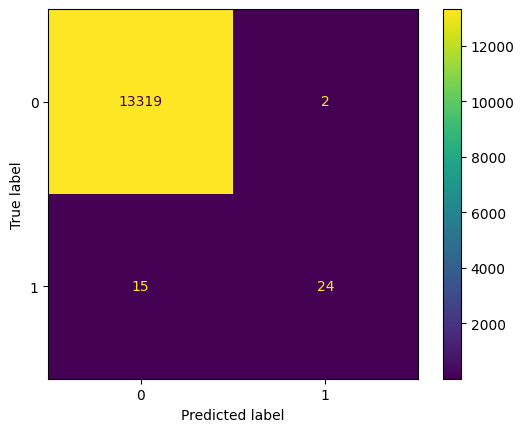

In [ ]:
from sklearn import metrics 

cm = metrics.confusion_matrix(val_labels, predictions_val_approx)
print(cm)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
F1 = metrics.f1_score(val_labels, predictions_val_approx, average = 'binary')
print(F1)

In [ ]:
test_ds = test_ds.reshape(test_ds.shape[0], 32, 32, 1)
predictions_test = model.predict(test_ds)
predictions = np.squeeze(predictions_test)

i = 0
predictions_test_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_test_approx.append(value_approx)

predictions_test_approx = np.asarray(predictions_test_approx)

280/280 [==============================] - 1s 4ms/step


[[8897    0]
 [  26   18]]
0.7384615384615384


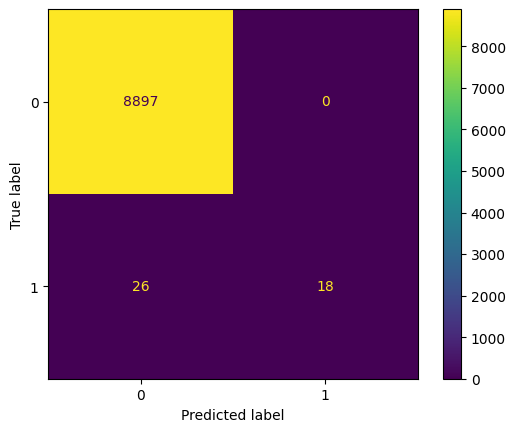

In [ ]:
cm_test = metrics.confusion_matrix(test_labels, predictions_test_approx)
print(cm_test)
cm_display = metrics.ConfusionMatrixDisplay(cm_test).plot()
print(F1)

In [ ]:
tp = []
fp = []
fn = []
tn = []

for i in range(len(test_ds)):
    if test_labels[i] == 1 and predictions_test_approx[i] == 1:
        tp.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 0 and predictions_test_approx[i] == 1:
        fp.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 1 and predictions_test_approx[i] == 0:
        fn.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 0 and predictions_test_approx[i] == 0:
        tn.append(i)

In [ ]:
test_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last4/response.drdf"]
labels_list = [ "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last4/sensors.root"]

file3, file3_labels, inner_photons_file3 = DatasetCut(labels_list, test_list)

In [ ]:
predictions_file = model.predict(file3)
predictions_file = np.squeeze(predictions_file)

1676/1676 [==============================] - 7s 4ms/step


In [ ]:
i = 0
predictions_approx = []
for value in predictions_file:
    if value >= 0.5:
        value_approx = 1
    if value < 0.5:
        value_approx = 0
    predictions_approx.append(value_approx)

predictions_approx = np.asarray(predictions_approx)

[[53077    26]
 [  218   308]]
0.7162790697674419


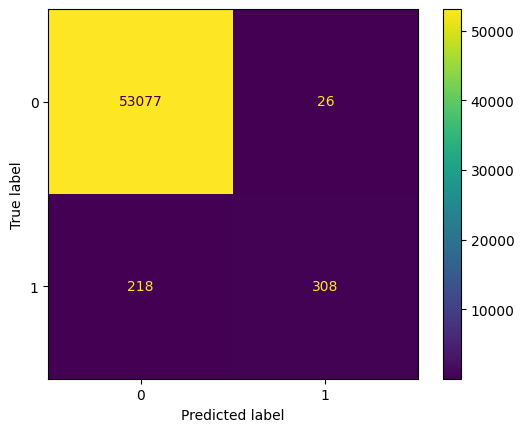

In [ ]:
#test_labels ha shape 4860
cm = metrics.confusion_matrix(file3_labels, predictions_approx)
print(cm)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
F1 = metrics.f1_score(file3_labels, predictions_approx, average = 'binary')
print(F1)

In [ ]:
tp_list = []
fp_list = []
fn_list = []
tn_list = []

for i in range(len(file3)):
    if file3_labels[i] == 1 and predictions_approx[i] == 1:
        tp_list.append(i)

for i in range(len(file3)):
    if file3_labels[i] == 0 and predictions_approx[i] == 1:
        fp_list.append(i)

for i in range(len(file3)):
    if file3_labels[i] == 1 and predictions_approx[i] == 0:
        fn_list.append(i)

for i in range(len(file3)):
    if file3_labels[i] == 0 and predictions_approx[i] == 0:
        tn_list.append(i)

In [ ]:
for i in tn_list:
    if inner_photons_file3[i] != 0:
        print(inner_photons_file3[i])

2447
425
386
1395
1509
12092
348
515
268
194
431
398
125
94
327
298
1378
47
779
57
1
163
324
2685
148
809
7
121
110
213
398
528
1910
319
46
49
19
239
774
192
492
265
3115
193
340
113
43
584
132
12
24
29
373
137
484
409
73
31
709
277
579
588
654
748
375
268
96
381
1655
72
573
1056
7548
244
210
412
274
339
707
575
140
33
1027
197
82
378
119
114
654
610
244
129
423
5
108
1035
139
85
346
250
278
394
101
98
59
172
51
215
553
100
134
388
51
341
152
363
765
606
2460
373
103
283
119
244
2958
382
301
115
48
10
767
1495
215
100
156
58
473
455
44
626
46
242
205
48
55
178
270
62
183
72
166
90
236
325
8
6
222
553
3
11
84
1412
290
132
243
438
215
6
75
43
68
46
72
7
18
238
476
7
639
1682
214
12251
157
1449
22
796
20
464
272
6933
220
16
73
124
290
137
933
334
552
347
91
156
62
567
402
839
3025
10
9643
181
986
256
14
199
50
125
223
199
670
876
461
834
455
65
7
151
19
38
402
1150
876
536
31
1963
118
848
37
545
7
67
337
48
1781
170
1838
108
38
134
571
638
236
1562
565
1016
7523
1096
65
52
10
411
84
1710


0


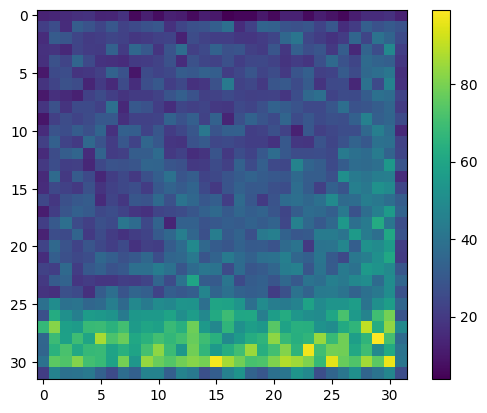

0


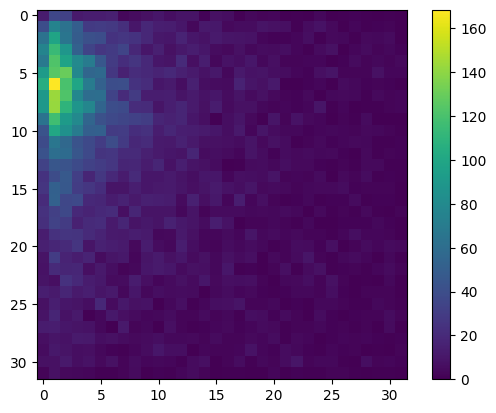

0


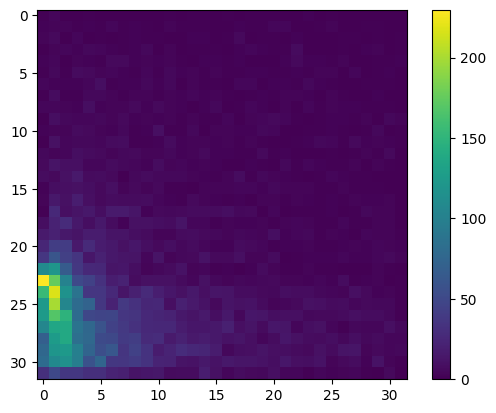

0


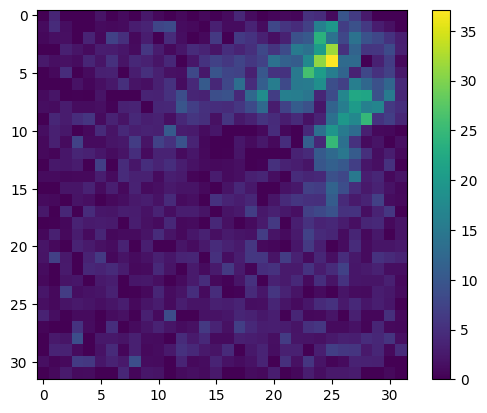

In [ ]:
for i in fp_list:
    if inner_photons_file3[i] == 0:
        print(inner_photons_file3[i])
        plt.imshow(file3[i])
        plt.colorbar()
        plt.show()

In [ ]:
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

with open('results.txt', 'a') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model.summary()
    print("ratio_thr, sum_thr, perc_val, perc_train: ", InitializeDatasetParameters())
    print("batch_size, epochs, input_shape, metric,loss_func: ", InitializeCNNParameters())
    print(cm_test)
    print(cm)
    sys.stdout = original_stdout # Reset the standard output to its original value